In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

# import os
# os.chdir("C:\\Users\\tamil\\OneDrive\\Documents\\Python Directory")

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, StratifiedKFold,KFold
from lightgbm import LGBMRegressor

# folder = "mh ecom/"

In [ ]:
# !conda install -y lightgbm

In [2]:
train = pd.read_csv("Train.csv",parse_dates=['Date'])
test = pd.read_csv("Test.csv",parse_dates=['Date'])

In [3]:
print(f"Train set dim :\n{train.shape}")
print(f"Test set dim :\n{test.shape}")

Train set dim :
(2452, 8)
Test set dim :
(1051, 7)


In [4]:
train.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,897.0
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,792.0
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,837.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470.0


In [5]:
max(train["Selling_Price"])

116289.0

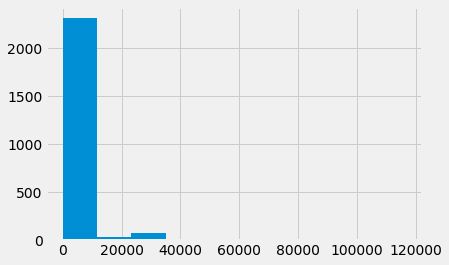

In [6]:
train["Selling_Price"].hist(bins = 10);

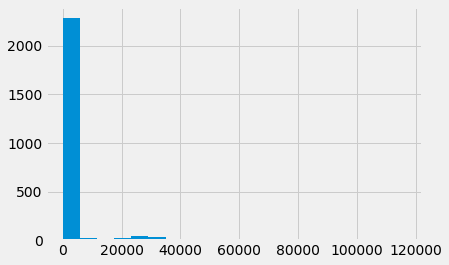

In [7]:
train["Selling_Price"].hist(bins = 20)

In [8]:
target = train["Selling_Price"]

In [9]:
target.skew()

5.538615617390771

In [10]:
np.log(target).skew()

1.5119087239695728

In [11]:
log_target = np.log(target)

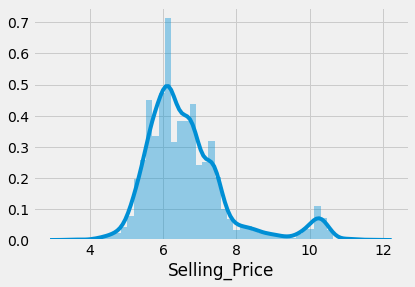

In [12]:
sns.distplot(log_target)

In [ ]:
print(np.log(1))
print(np.log(2))
print(np.log1p(1))

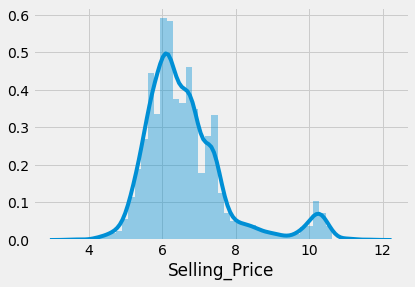

In [13]:
sns.distplot(np.log1p(target))

In [14]:
from scipy.stats import boxcox, skew

bx,lam = boxcox(target)
skew(bx)

-0.03443380910074759

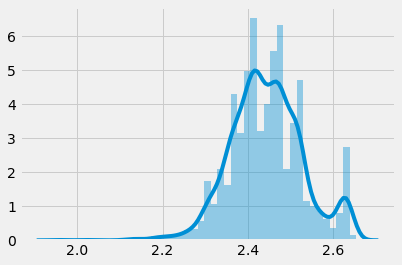

In [15]:
sns.distplot(bx)

In [16]:
train_ind = train.drop("Selling_Price", axis = 1)
train_ind.shape

(2452, 7)

In [17]:
df = pd.concat([train_ind, test], axis = 0)
df.shape

(3503, 7)

In [18]:
df.isnull().sum()

Product          0
Product_Brand    0
Item_Category    0
Subcategory_1    0
Subcategory_2    0
Item_Rating      0
Date             0
dtype: int64

In [19]:
category_list = ["Item_Category","Subcategory_1","Subcategory_2","Product_Brand"]

for var in category_list:
    print("=================================")
    print("{:10} {:10}".format(var, df[var].nunique()))

Item_Category         95
Subcategory_1        142
Subcategory_2        395
Product_Brand       1313


# Handling DateTime Variable

In [21]:
# Creating features from DateTime
from datetime import datetime

df["Weekday"] = [datetime.weekday(date) for date in df["Date"]]
# df["Year"] = [date.year for date in df["Date"]]
df["Month"] = [date.month for date in df["Date"]]
df["Day"] = [date.day for date in df["Date"]]
# df['Week'] = [date.week for date in df["Date"]]
df['Quarter'] = [date.quarter for date in df["Date"]]
# df['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df["Date"]]
df["Month_start"] = [date.is_month_start for date in df["Date"]]
# df["Minute"] = [date.minute for date in df["DateTime"]]
# df["Hour"] = [date.hour for date in df["DateTime"]]
df["DayOfYear"] = [date.dayofyear for date in df["Date"]]
# df["Is_quater"] = [date.is_quarter_start for date in df["Date"]]

In [22]:
df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Weekday,Month,Day,Quarter,Month_start,DayOfYear
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,4,2,3,1,False,34
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,2,7,1,3,True,182
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,5,1,12,1,False,12
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,4,12,12,4,False,346
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,3,12,12,4,False,346


# FEARTURE ENGINEERING 

In [20]:
train["Product"].nunique()

2452

In [24]:
df['Subcategory_1'].unique()

array(['bags', 'women s clothing', 'showpieces', 'eye care',
       'men s clothing', 'table decor handicrafts', 'women s footwear',
       'cookware', 'wall decor clocks', 'accessories spare parts',
       'computer components', 'unknown', 'health nutrition', 'rings',
       'candles fragrances', 'laptop accessories', 'coffee mugs',
       'kids clothing', 'necklaces chains', 'kitchen dining linen',
       'network components', 'luggage travel',
       'bangles bracelets armlets', 'fragrances', 'school supplies',
       'accessories', 'action figures', 'pet furniture',
       'car bike accessories', 'tablet accessories', 'hair care',
       'camera accessories', 'baby kids gifts', 'academic texts',
       'kids infant footwear', 'combos and kits', 'baby bedding', 'tools',
       'infant wear', 'office supplies', 'kitchen tools',
       'mobile accessories', 'wrist watches', 'pendants lockets',
       'men s footwear', 'outdoor adventure', 'frames', 'bed linen',
       'living room', '

In [25]:
df['Subcategory_1']=df['Subcategory_1'].replace('unknown', np.nan)
df['Subcategory_2']=df['Subcategory_2'].replace('unknown', np.nan)

In [26]:
df.isnull().sum()

Product            0
Product_Brand      0
Item_Category      0
Subcategory_1     66
Subcategory_2    324
Item_Rating        0
Date               0
Weekday            0
Month              0
Day                0
Quarter            0
Month_start        0
DayOfYear          0
dtype: int64

In [27]:
cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
for col in cols_with_missing:
    df[col + '_was_missing'] = df[col].isnull()

In [28]:
df.isnull().sum()

Product                        0
Product_Brand                  0
Item_Category                  0
Subcategory_1                 66
Subcategory_2                324
Item_Rating                    0
Date                           0
Weekday                        0
Month                          0
Day                            0
Quarter                        0
Month_start                    0
DayOfYear                      0
Subcategory_1_was_missing      0
Subcategory_2_was_missing      0
dtype: int64

In [29]:
df['Subcategory_1'].fillna('unknown',inplace=True)
# df['Subcategory_1'] = df['Subcategory_1'].fillna(df['Subcategory_1'].mode()[0])
# df['Subcategory_2'] = df['Subcategory_2'].fillna(df['Subcategory_2'].mode()[0])

In [30]:
df.isnull().sum()

Product                        0
Product_Brand                  0
Item_Category                  0
Subcategory_1                  0
Subcategory_2                324
Item_Rating                    0
Date                           0
Weekday                        0
Month                          0
Day                            0
Quarter                        0
Month_start                    0
DayOfYear                      0
Subcategory_1_was_missing      0
Subcategory_2_was_missing      0
dtype: int64

In [34]:
def fast_mode(df, key_cols, value_col):
    """ 
    Calculate a column mode, by group, ignoring null values. 

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame over which to calcualate the mode. 
    key_cols : list of str
        Columns to groupby for calculation of mode.
    value_col : str
        Column for which to calculate the mode. 

    Return
    ------ 
    pandas.DataFrame
        One row for the mode of value_col per key_cols group. If ties, 
        returns the one which is sorted first. 
    """
    return (df.groupby(key_cols + [value_col]).size() 
              .to_frame('counts').reset_index() 
              .sort_values('counts', ascending=False) 
              .drop_duplicates(subset=key_cols)).drop(columns='counts')

In [36]:
df.loc[df.Subcategory_2.isnull(), ['Subcategory_1','Subcategory_2']].head()

,Subcategory_1,Subcategory_2
12,unknown,NaN
15,rings,NaN
16,unknown,NaN
45,rings,NaN
47,rings,NaN


In [37]:
df.loc[df.Subcategory_2.isnull(), 'Subcategory_1'].unique()

array(['unknown', 'rings', 'pet furniture', 'hh aviator sunglasses',
       'jewellery sets', 'earrings', 'nose rings studs',
       'damemoda wayfarer sunglasses', 'eye glass wayfarer sunglasses',
       'pendants lockets', 'hh wayfarer sunglasses', 'living',
       'smart door locks', 'mikado aviator sunglasses',
       'redex cat eye sunglasses', 'aligatorr aviator sunglasses',
       'true home decor festive needs'], dtype=object)

In [77]:
((df.groupby(['Subcategory_1']+ ['Subcategory_2']).size().to_frame('counts')
 .reset_index().sort_values('counts', ascending=False)
 .drop_duplicates(subset=['Subcategory_1'])).drop(columns='counts').set_index('Subcategory_1')
.Subcategory_2).loc['rings']

'manirathnum manirathnum garnet peridot gemston'

In [91]:
df.Subcategory_1.map((df.groupby(['Subcategory_1']+ ['Subcategory_2']).size().to_frame('counts')
 .reset_index().sort_values('counts', ascending=False)
 .drop_duplicates(subset=['Subcategory_1'])).drop(columns='counts').set_index('Subcategory_1')
.Subcategory_2)

0                                              hand bags
1                                           western wear
2                                                 ethnic
3                                      h2o plus eye care
4                                               t shirts
5                                             showpieces
6                                           casual shoes
7                                              pots pans
8                                   wall decals stickers
9                                  car interior exterior
10                                            processors
11                                          western wear
12                                               unknown
13                                   protein supplements
14                                                ethnic
15        manirathnum manirathnum garnet peridot gemston
16                                               unknown
17                             

In [80]:
df.reset_index(inplace=True)
df.loc[df.Subcategory_2.isnull(), 'Subcategory_2'] = df.Subcategory_1.map(fast_mode(df, ['Subcategory_1'], 'Subcategory_2').set_index('Subcategory_1').Subcategory_2)
df.loc[df.Subcategory_2.isnull(), ['Subcategory_1','Subcategory_2']].head()

,Subcategory_1,Subcategory_2
12,unknown,NaN
16,unknown,NaN
60,pet furniture,NaN
93,unknown,NaN
94,pet furniture,NaN


In [82]:
df.loc[15,['Subcategory_1','Subcategory_2']]

Subcategory_1                                             rings
Subcategory_2    manirathnum manirathnum garnet peridot gemston
Name: 15, dtype: object

In [83]:
del df['index']
df['Subcategory_2'].fillna('unknown',inplace=True)

In [89]:
df.loc[df['Subcategory_2'] == 'unknown', 'Product'].count()

137

In [90]:
df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Weekday,Month,Day,Quarter,Month_start,DayOfYear,Subcategory_1_was_missing,Subcategory_2_was_missing
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,4,2,3,1,False,34,False,False
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,2,7,1,3,True,182,False,False
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,5,1,12,1,False,12,False,False
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,4,12,12,4,False,346,False,False
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,3,12,12,4,False,346,False,False


### Replacing Unknown with rings

In [ ]:
df["Subcategory_1"] = df["Subcategory_1"].replace("unknown","rings")

In [ ]:
df.columns

In [ ]:
to_drop_list = ["Date"]

df = df.drop(to_drop_list, axis = 1)

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)

In [ ]:
#Labe enc Round 1
category_list = ["Product_Brand","Product","Item_Category","Subcategory_1","Subcategory_2"]

from sklearn.preprocessing import LabelEncoder
for var in category_list:
    lab_enc = LabelEncoder()
    df[var] = lab_enc.fit_transform(df[var].astype(str))

In [ ]:
# round4

fe_pol = (df.groupby('Product_Brand').size()) / len(df)
df['Product_Brand_fe'] = df['Product_Brand'].apply(lambda x : fe_pol[x])

fe_cat_1 = (df.groupby('Subcategory_1').size()) / len(df)
df['Subcategory_1_fe'] = df['Subcategory_1'].apply(lambda x : fe_cat_1[x])

fe_cat_2 = (df.groupby('Subcategory_2').size()) / len(df)
df['Subcategory_2_fe'] = df['Subcategory_2'].apply(lambda x : fe_cat_2[x])

fe_item = (df.groupby('Item_Category').size()) / len(df)
df['Item_Category_fe'] = df['Item_Category'].apply(lambda x : fe_item[x])

In [ ]:
df = df.drop("Subcategory_1_was_missing", axis = 1)
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
scaler = StandardScaler()
scaler_array = scaler.fit_transform(df)
scaled_data = pd.DataFrame(scaler_array, columns = df.columns)

In [ ]:
data_train = scaled_data[:train.shape[0]]
data_test = scaled_data[train.shape[0]:]

# BLENDING (CHECK)

In [ ]:
X = data_train
Y = log_target

train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size = 0.30, random_state = 100)

In [ ]:
xgboost = XGBRegressor(colsample_bytree=0.5, learning_rate=0.05, max_depth=9,
             min_child_weight=4, n_estimators=150, subsample=0.7,objective="reg:squarederror")

xgboost.fit(train_x, train_y)


rf = RandomForestRegressor(bootstrap=True, max_features=0.45,
                           min_samples_leaf=1, min_samples_split=5, n_estimators=100)
rf.fit(train_x, train_y)


lgbm = LGBMRegressor(n_estimators=250, num_leaves=127, max_depth=8,min_child_samples=4,
                      learning_rate=0.02, colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=2)
lgbm.fit(train_x, train_y)


gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, max_features='sqrt', min_samples_leaf=15,
                                min_samples_split=10, loss='huber', random_state =42)
gb.fit(train_x, train_y)

In [ ]:
#Weighted Average Predictions
def blend_models_predict(X):
    print(xgboost.predict(X.loc[[0]]))
    print(lgbm.predict(X.loc[[0]]))
    print(rf.predict(X.loc[[0]]))
    print(gb.predict(X.loc[[0]]))
    return (0.2 * (xgboost.predict(X)) + (0.2 * lgbm.predict(X)) + (0.4 * rf.predict(X)) + (0.2 * gb.predict(X)))

In [ ]:
def rmsle(Y, y_pred):
    return np.sqrt(mean_squared_error(Y, y_pred))

In [ ]:
print('RMSLE score for Blended Model on TEST Data:')
print(rmsle(test_y, blend_models_predict(test_x)))

In [ ]:
print((0.2 * (7.107718) + (0.2 * 7.09891793) + (0.4 * 7.23474492) + (0.2 * 7.04418134)))
print((7.107718*0.2) + (7.09891793*0.2) + (7.23474492*0.4) + (7.04418134*0.2))
print((7.107718/5) + (7.09891793/5) + (7.23474492/2.5) + (7.04418134/5))

In [ ]:
1/2.5

In [ ]:
(7.107718 + 7.09891793 + 7.23474492 + 7.04418134)/4

# BLENDING FINAL

In [ ]:
xgboost = XGBRegressor(colsample_bytree=0.5, learning_rate=0.05, max_depth=9,
             min_child_weight=4, n_estimators=150, subsample=0.7,objective="reg:squarederror")
xgboost.fit(X, Y)


rf = RandomForestRegressor(bootstrap=True, max_features=0.45,
                           min_samples_leaf=1, min_samples_split=5, n_estimators=100)
rf.fit(X, Y)


lgbm = LGBMRegressor(n_estimators=250, num_leaves=127, max_depth=8,min_child_samples=4,
                      learning_rate=0.02, colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=2)
lgbm.fit(X, Y)


gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, max_features='sqrt', min_samples_leaf=15,
                                min_samples_split=10, loss='huber', random_state =42)
gb.fit(X, Y)

In [ ]:
def rmse(Y, y_pred):
    return np.sqrt(mean_squared_error(Y, y_pred))

In [ ]:
print('RMSE score for Blended Model on Train Data:')
print(rmse(Y, blend_models_predict(X)))

In [ ]:
blended_predictions = np.exp(blend_models_predict(data_test))

In [ ]:
sub=pd.DataFrame(columns=["Selling_Price"])
sub["Selling_Price"] = blended_predictions
writer = pd.ExcelWriter(folder+'submission_blended_final_final.xlsx')
sub.to_excel(writer,'Sheet5')
writer.save()